In [1]:
import io
import zipfile
import pandas
from plotnine import *
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

archive_name = 'grenoble_2018-10-09_1811676.zip'
archive = zipfile.ZipFile(archive_name)

def get_csv(archive, filename, newcolumns={}):
    df= pandas.read_csv(io.BytesIO(archive.read(filename)), names=['function', 'm', 'n', 'k', 'start', 'duration'])
    df['size_cube'] = -1
    df.loc[df.function == 'dtrsm', 'size_cube'] = df.m * df.n**2
    df.loc[df.function == 'dgemm', 'size_cube'] = df.m * df.n * df.k
    df['min_size'] = -1
    min_mn  = df[['m', 'n'     ]].min(axis=1)
    min_mnk = df[['m', 'n', 'k']].min(axis=1)
    df.loc[df.function == 'dtrsm', 'min_size'] = min_mn
    df.loc[df.function == 'dgemm', 'min_size'] = min_mnk
    df['max_size'] = df[['m', 'n', 'k']].max(axis=1)
    df['flops'] = df['size_cube'] * 2 / df['duration']
    df['index'] = range(len(df))
    for name, val in newcolumns.items():
        df[name] = val
    return df[df.index > 10]  # the few first calls may be outliers

def get_op(df, op):
    return df[df.function == op]


result_multicore = get_csv(archive, 'result_multicore.csv')
result_monocore_nocontention = get_csv(archive, 'result_monocore.csv', {'contention': False})
result_monocore_contention = get_csv(archive, 'result_monocore_contention.csv', {'contention': True})
result_monocore = pandas.concat([result_monocore_nocontention, result_monocore_contention])

def logify(plot, log_x=True, log_y=True):
    print(plot)
    if log_x:
        plot += scale_x_log10()
    if log_y:
        plot += scale_y_log10()
    print(plot)

result_multicore.head()

,function,m,n,k,start,duration,size_cube,min_size,max_size,flops,index
11,dgemm,16256,128,128,0.037159,0.003217,266338304,128,16256,1.655563e+11,11
12,dtrsm,7936,128,-1,0.040380,0.001511,130023424,128,7936,1.720614e+11,12
13,dtrsm,7936,128,-1,0.041895,0.001374,130023424,128,7936,1.892128e+11,13
14,dtrsm,7936,128,-1,0.043272,0.001353,130023424,128,7936,1.922525e+11,14
15,dgemm,16256,7936,128,0.044626,0.110402,16512974848,128,16256,2.991416e+11,15


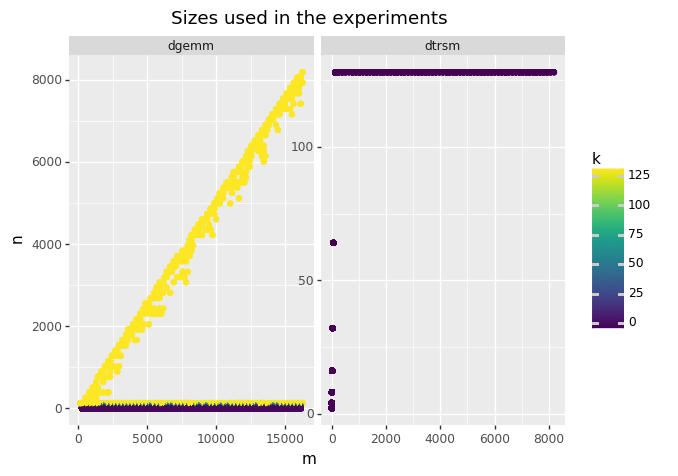

<ggplot: (-9223363285833657789)>


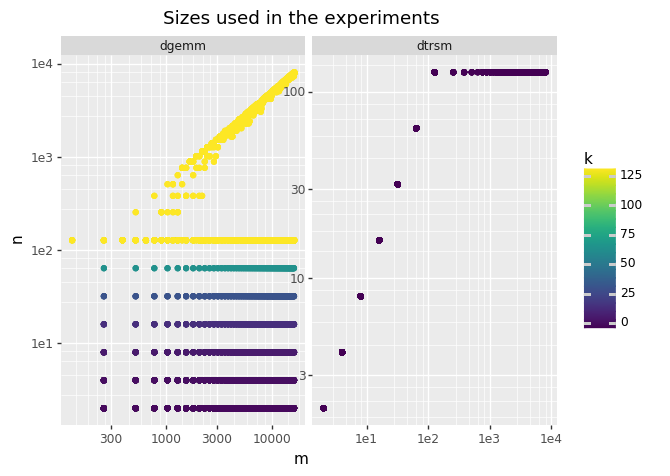

<ggplot: (-9223363285833657789)>


In [2]:
logify(ggplot(result_monocore_contention, aes(x='m', y='n', color='k')) + geom_point() + facet_wrap('function', scales='free') + ggtitle('Sizes used in the experiments'))

## Multicore

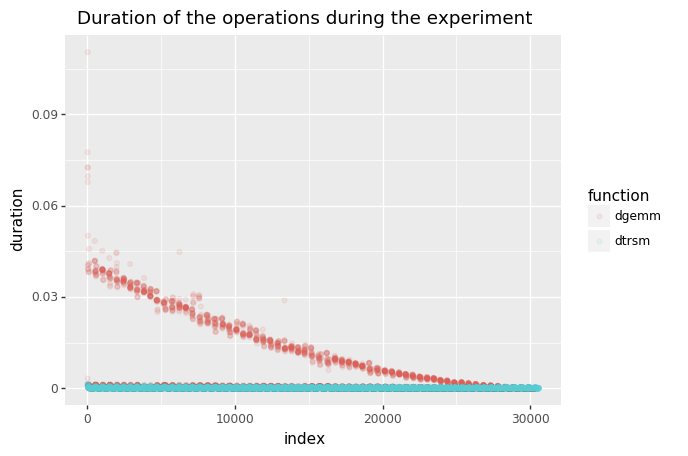

<ggplot: (8750959745242)>


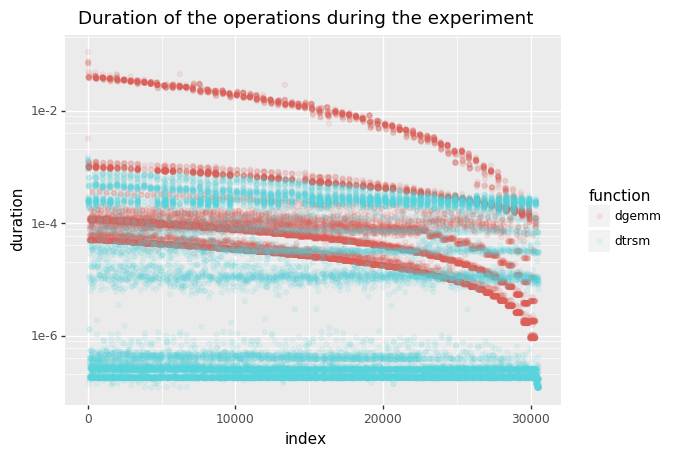

<ggplot: (8750959745242)>


In [3]:
logify(ggplot(result_multicore, aes(x='index', y='duration', color='function')) + geom_point(alpha=0.1) + ggtitle('Duration of the operations during the experiment'), log_x=False)

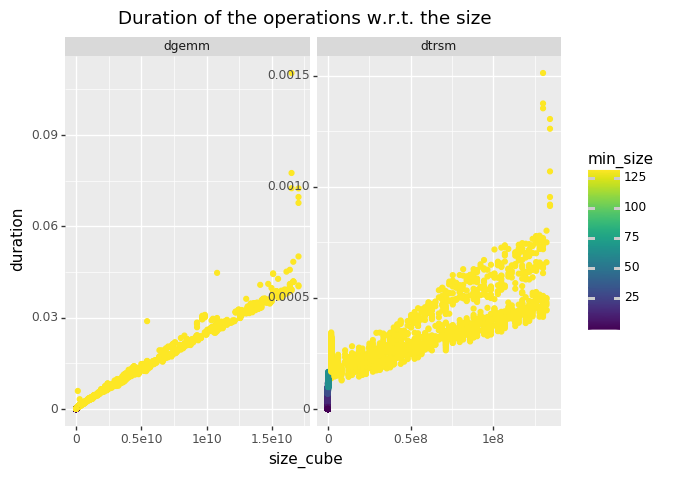

<ggplot: (-9223363285894990199)>


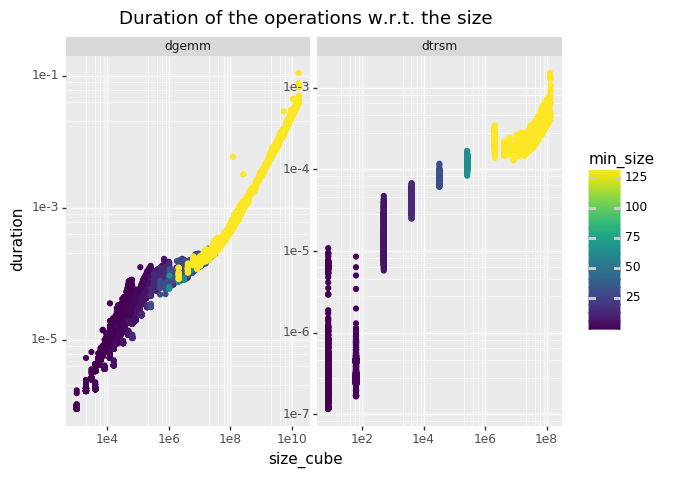

<ggplot: (-9223363285894990199)>


In [4]:
logify(ggplot(result_multicore, aes(x='size_cube', y='duration', color='min_size')) + geom_point() + facet_wrap('function', scales='free') + ggtitle('Duration of the operations w.r.t. the size'))

861.7421442270748


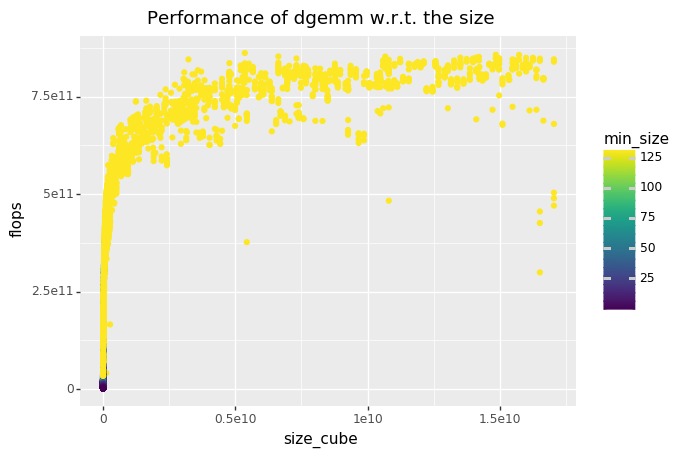

<ggplot: (-9223363285908216502)>

In [5]:
print(get_op(result_multicore, 'dgemm').flops.max()*1e-9)
ggplot(get_op(result_multicore, 'dgemm'), aes(x='size_cube', y='flops', color='min_size')) + geom_point() + expand_limits(y=0) + ggtitle('Performance of dgemm w.r.t. the size')

## Monocore, with and without contention

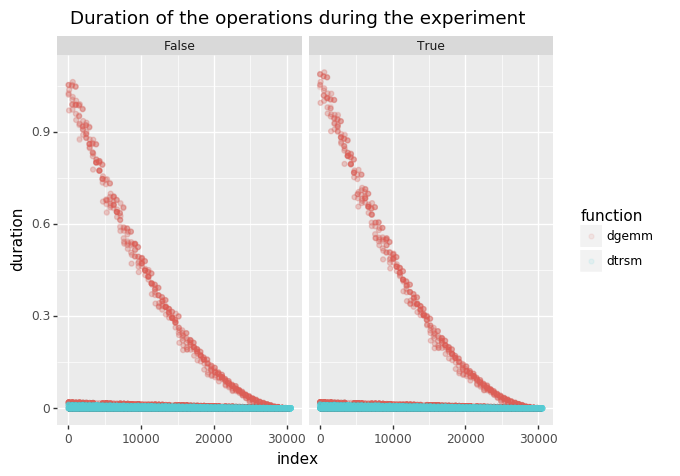

<ggplot: (8751021144808)>


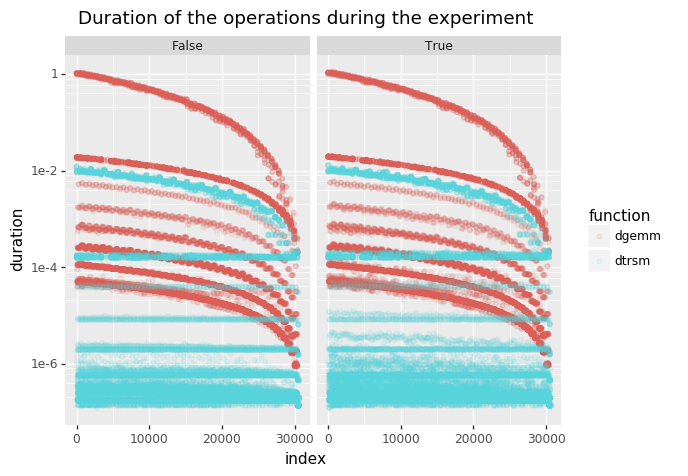

<ggplot: (8751021144808)>


In [6]:
logify(ggplot(result_monocore, aes(x='index', y='duration', color='function')) + geom_point(alpha=0.1) + facet_wrap('contention') + ggtitle('Duration of the operations during the experiment'), log_x=False)

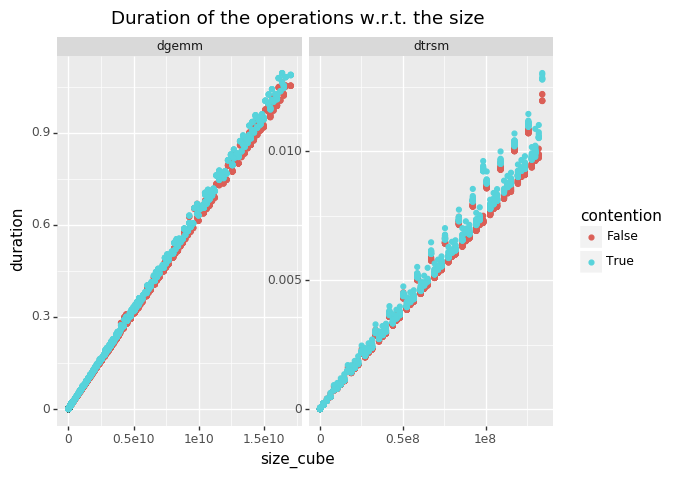

<ggplot: (-9223363285833631172)>


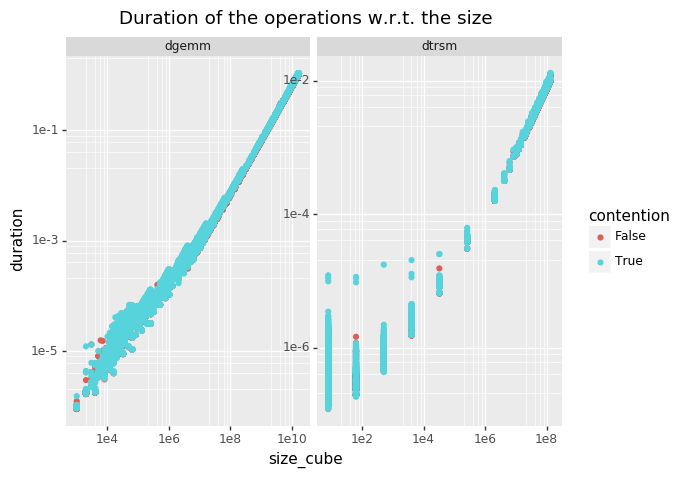

<ggplot: (-9223363285833631172)>


In [7]:
logify(ggplot(result_monocore, aes(x='size_cube', y='duration', color='contention')) + geom_point() + facet_wrap('function', scales='free') + ggtitle('Duration of the operations w.r.t. the size'))

contention
False    32.659603
True     31.801411
Name: flops, dtype: float64


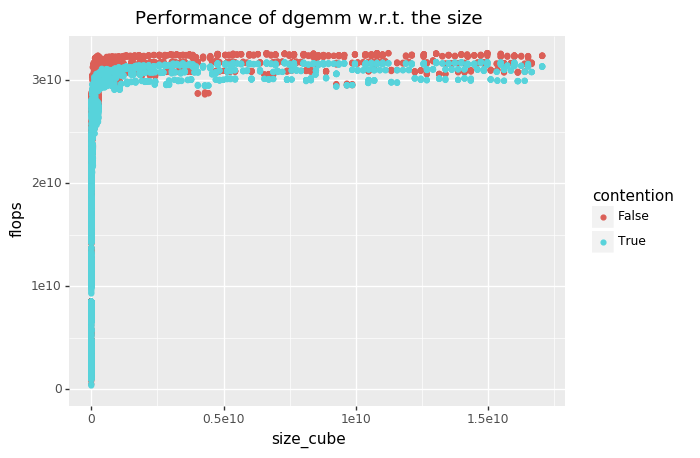

<ggplot: (-9223363285928056046)>

In [8]:
print(get_op(result_monocore, 'dgemm').groupby('contention').flops.max()*1e-9)
ggplot(get_op(result_monocore, 'dgemm'), aes(x='size_cube', y='flops', color='contention')) + geom_point() + expand_limits(y=0) + ggtitle('Performance of dgemm w.r.t. the size')

## Regression for the monocore experiment

In [9]:
import statsmodels.formula.api as sm

intercept  : 2.611517e-04
coefficient: 6.440837e-11


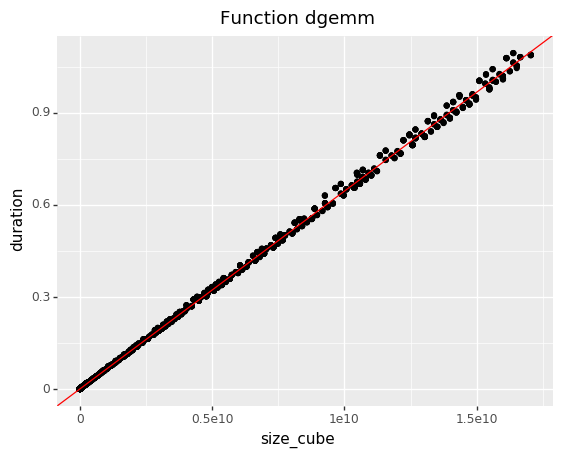

<ggplot: (-9223363285929821664)>

In [10]:
def compute_lm(df):
    reg = sm.ols(data=df, formula='duration ~ size_cube').fit().params
    print('intercept  : %e' % reg['Intercept'])
    print('coefficient: %e' % reg['size_cube'])
    func = df.function.unique()
    assert len(func) == 1
    func = func[0]
    return ggplot(df, aes(x='size_cube', y='duration')) + geom_point() + geom_abline(intercept=reg['Intercept'], slope=reg['size_cube'], color='red') + ggtitle('Function %s' % func)

compute_lm(get_op(result_monocore_contention, 'dgemm'))

intercept  : 1.182330e-06
coefficient: 7.984359e-11


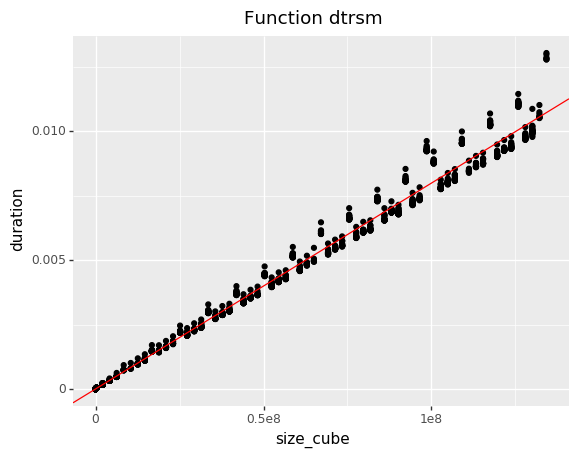

<ggplot: (8750924966639)>

In [11]:
compute_lm(get_op(result_monocore_contention, 'dtrsm'))

## Regression for the multicore experiment

intercept  : 9.905042e-05
coefficient: 2.548998e-12


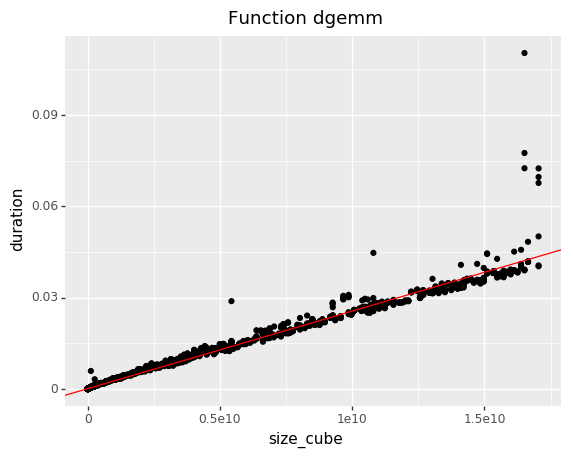

<ggplot: (8750924968624)>

In [12]:
compute_lm(get_op(result_multicore, 'dgemm'))

intercept  : 3.975362e-05
coefficient: 4.524788e-12


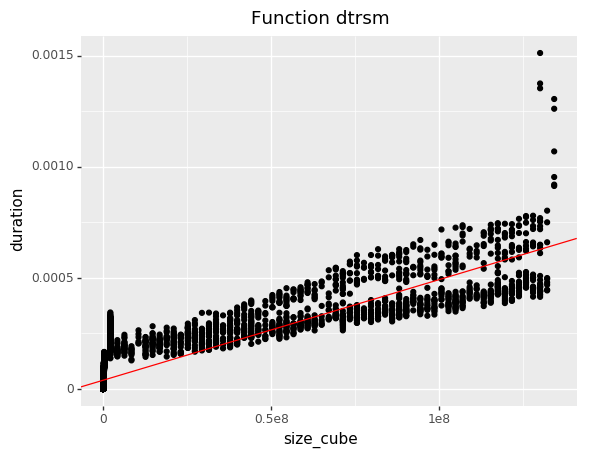

<ggplot: (8750925509801)>

In [13]:
compute_lm(get_op(result_multicore, 'dtrsm'))